# Autotune Peak finding and fitting paramters

Basic idea is to take a representative data set and scan through sigmas and thresholds and pick the one with the most "good" peaks and least found peaks (i.e. optimize for the most information for the least amount of work). Filters should be relatively agnostic  but will need some _apriori_ knowledge

In [1]:
%matplotlib notebook
import skimage.external.tifffile as tif
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
%load_ext line_profiler
%load_ext autoreload
%autoreload 2
from peaks.peakfinder import PeakFinder, better_blob_dog

In [2]:
tifs = glob.glob("PALM Drift Correction Analysis/Raw Data for Slab0/*.tif")

In [117]:
data = tif.imread(tifs[np.random.randint(len(tifs))])

<IPython.core.display.Javascript object>


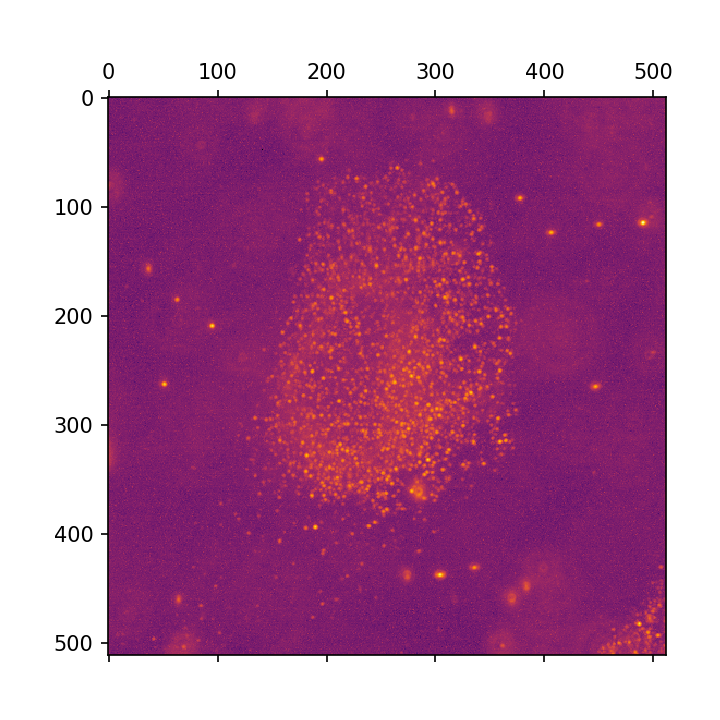

In [119]:
plt.matshow(data.max(0), cmap="inferno", norm=PowerNorm(0.25))

<IPython.core.display.Javascript object>


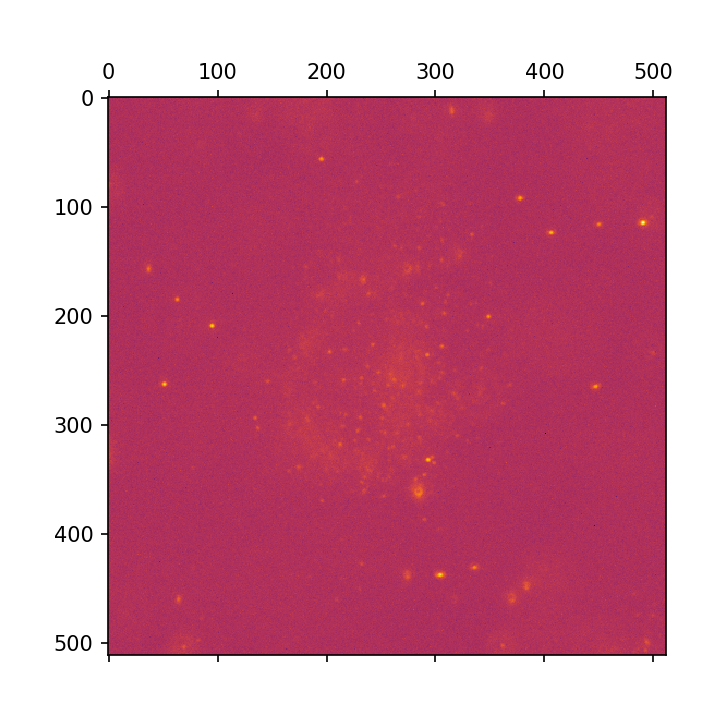

In [118]:
plt.matshow(data[10], cmap="inferno", norm=PowerNorm(0.25))

In [120]:
def filter_df(df, amp=10):
    df = df.dropna()
    df = df[
        (df.x0_e < 0.5) &
        (df.y0_e < 0.5) &
        (df.offset < 1000) &
        (df.SNR > 5) &
        (df.amp > amp) &
        (abs(df.sigma_x) < 3.5) &
        (abs(df.sigma_y) < 3.5)
    ]
    return df

In [121]:
fit_win = 7
list_pfs = []
threshes = np.arange(0, 15, 0.1)
for i in threshes:
    pf = PeakFinder(data[10], 1.3, i)
    pf.find_blobs()
    pf.remove_edge_blobs(fit_win)
    pf.prune_blobs(fit_win)
    %time pf.fit_blobs(fit_win, quiet=True)
#     print("="*40)
#     print("Thresh = {}".format(i))
#     print("Found blobs = ", len(pf.blobs))
#     print("Fit blobs = ", len(filter_df(pf.fits)))
    list_pfs.append(pf)

Wall time: 1min 8s
Wall time: 1min 9s
Wall time: 1min 10s
Wall time: 1min 10s
Wall time: 1min 13s
Wall time: 1min 16s
Wall time: 1min 14s
Wall time: 1min 7s
Wall time: 1min 9s
Wall time: 1min 10s
Wall time: 1min 7s
Wall time: 1min 7s
Wall time: 1min 4s
Wall time: 1min 2s
Wall time: 1min 1s
Wall time: 59.2 s
Wall time: 58.9 s
Wall time: 54.4 s
Wall time: 52.6 s
Wall time: 52.3 s
Wall time: 47.1 s
Wall time: 44.8 s
Wall time: 41.6 s
Wall time: 37.6 s
Wall time: 35 s
Wall time: 31.7 s
Wall time: 28.3 s
Wall time: 25.5 s
Wall time: 23.6 s
Wall time: 20.8 s
Wall time: 17.8 s
Wall time: 16.1 s
Wall time: 14.3 s
Wall time: 11.9 s
Wall time: 10.9 s
Wall time: 9.81 s
Wall time: 8.88 s
Wall time: 7.92 s
Wall time: 6.56 s
Wall time: 5.7 s
Wall time: 5.05 s
Wall time: 3.98 s
Wall time: 3.5 s
Wall time: 3.06 s
Wall time: 2.83 s
Wall time: 2.49 s
Wall time: 2.49 s
Wall time: 2 s
Wall time: 1.79 s
Wall time: 1.78 s
Wall time: 1.7 s
Wall time: 1.49 s
Wall time: 1.41 s
Wall time: 1.35 s
Wall time: 1.4 

<IPython.core.display.Javascript object>


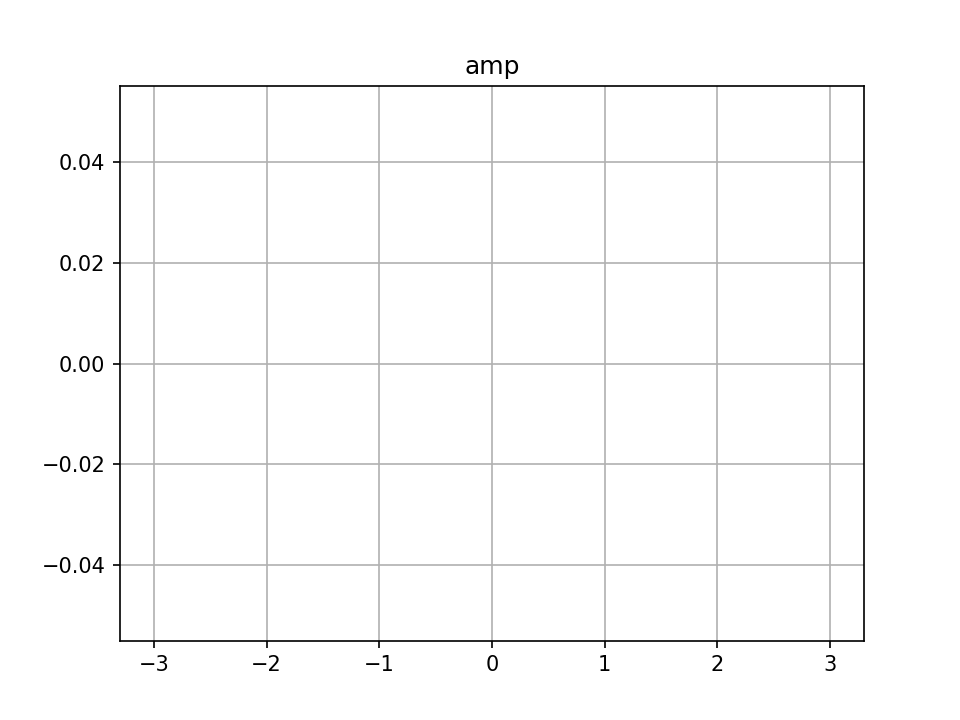

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002596DEBEE10>]], dtype=object)

In [122]:
abs(list_pfs[0].fits).hist("amp", bins=np.linspace(-3, 3))

In [123]:
found_peaks = np.array([len(pf.blobs) for pf in list_pfs])
fit_peaks = np.array([len(filter_df(pf.fits, 30)) for pf in list_pfs])

<IPython.core.display.Javascript object>


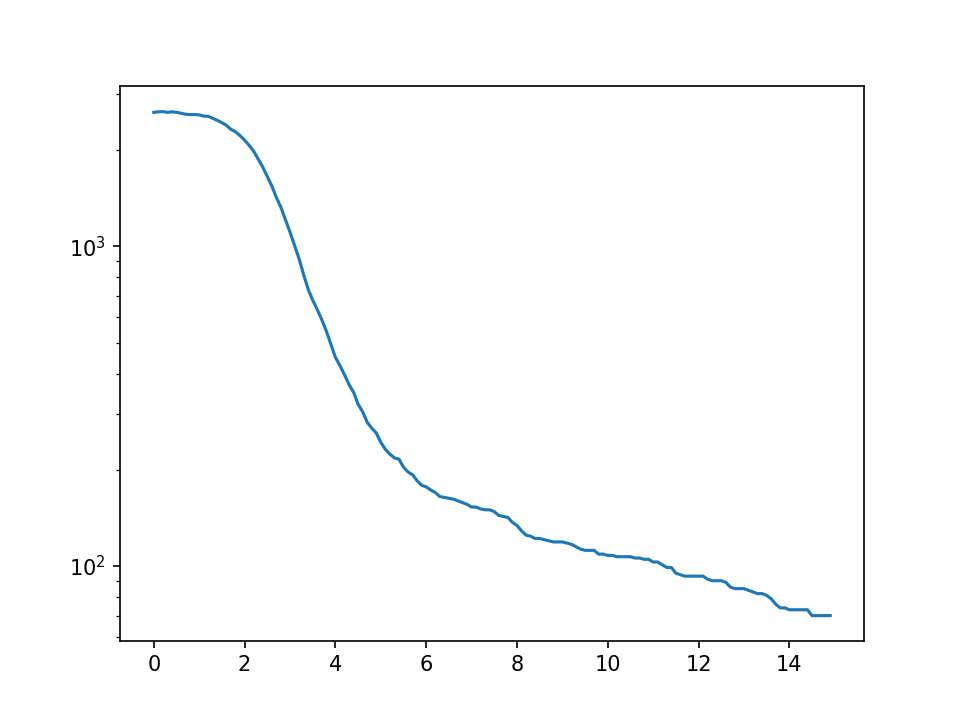

In [124]:
plt.figure()
plt.semilogy(threshes, found_peaks)

<IPython.core.display.Javascript object>


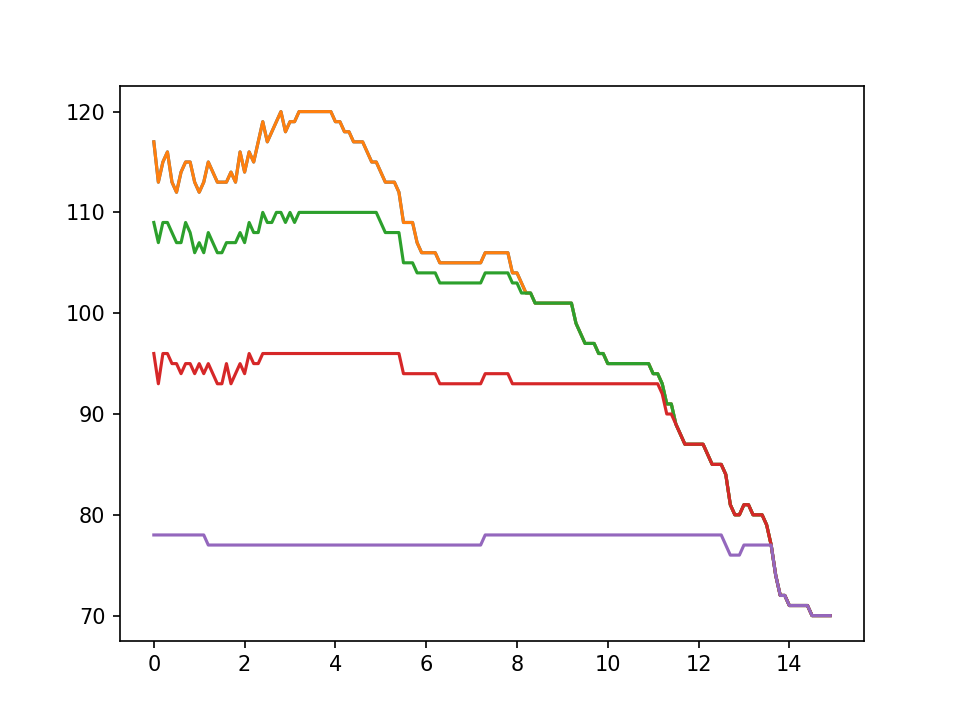

In [125]:
plt.figure()
for i in (0, 20, 40, 50, 60):
    fit_peaks = np.array([len(filter_df(pf.fits, i)) for pf in list_pfs])
    plt.plot(threshes, fit_peaks, label=i)

<IPython.core.display.Javascript object>


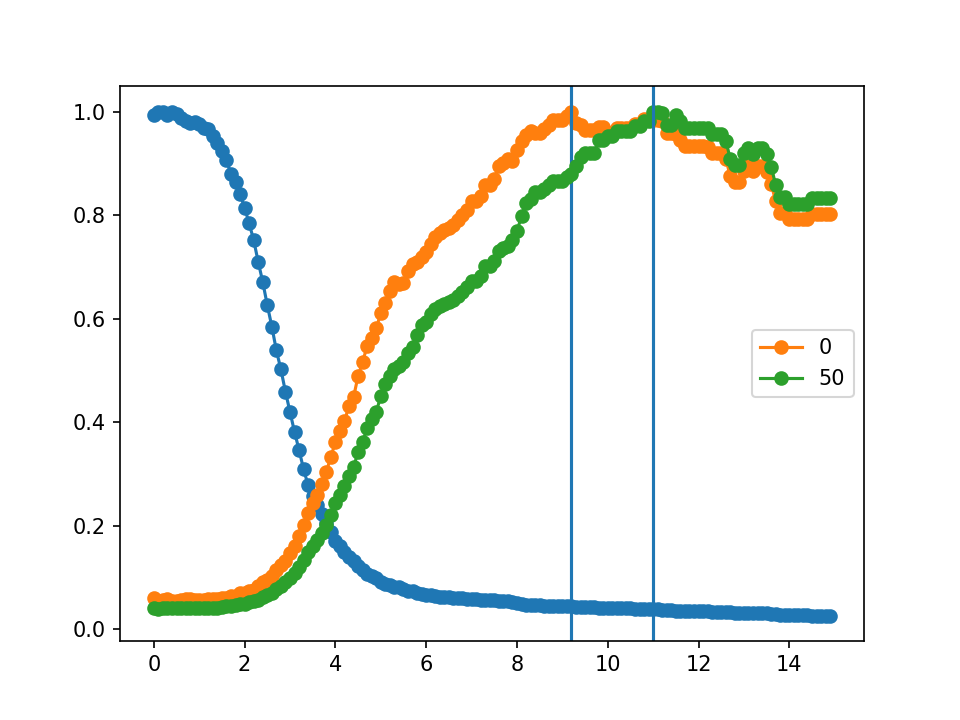

In [126]:
plt.figure()
plt.plot(threshes, found_peaks/found_peaks.max(), "-o")
for i in (0, 50):
    fit_peaks = np.array([len(filter_df(pf.fits, i)) for pf in list_pfs])
    fom = (fit_peaks/fit_peaks.max())**2 / found_peaks
    plt.plot(threshes, fom/fom.max(), "-o", label=i)
    plt.axvline(threshes[fom.argmax()])
#     plt.plot(threshes, fit_peaks/fit_peaks.max(), "-o")
plt.legend()